## PREVENDO O NUMERO DE MESES PARA FINALIZAR A VACINAÇÃO DE COVID NO BRASIL UTILIZANDO MODELOS AUTO REGRESSIVOS

#### Importando bibliotecas

In [1567]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings 

warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (12,5)

#### Lendo o dataset

In [1568]:
df = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [1569]:
df.head(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.00000,5.00000,nan,nan,nan,nan,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
1,AFG,Asia,Afghanistan,2020-02-25,5.00000,0.00000,nan,nan,nan,nan,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
2,AFG,Asia,Afghanistan,2020-02-26,5.00000,0.00000,nan,nan,nan,nan,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
3,AFG,Asia,Afghanistan,2020-02-27,5.00000,0.00000,nan,nan,nan,nan,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
4,AFG,Asia,Afghanistan,2020-02-28,5.00000,0.00000,nan,nan,nan,nan,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
5,AFG,Asia,Afghanistan,2020-02-29,5.00000,0.00000,0.71400,nan,nan,0.00000,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
6,AFG,Asia,Afghanistan,2020-03-01,5.00000,0.00000,0.71400,nan,nan,0.00000,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
7,AFG,Asia,Afghanistan,2020-03-02,5.00000,0.00000,0.00000,nan,nan,0.00000,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
8,AFG,Asia,Afghanistan,2020-03-03,5.00000,0.00000,0.00000,nan,nan,0.00000,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan
9,AFG,Asia,Afghanistan,2020-03-04,5.00000,0.00000,0.00000,nan,nan,0.00000,...,nan,nan,37.74600,0.50000,64.83000,0.51100,nan,nan,nan,nan


#### Seleciona a localidade para analise, nesse caso, Brasil

In [1570]:
df_brasil = df[df['location'] == "Brazil"]

In [1571]:
df_brasil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 16424 to 17044
Data columns (total 65 columns):
iso_code                                   621 non-null object
continent                                  621 non-null object
location                                   621 non-null object
date                                       621 non-null object
total_cases                                621 non-null float64
new_cases                                  620 non-null float64
new_cases_smoothed                         616 non-null float64
total_deaths                               601 non-null float64
new_deaths                                 601 non-null float64
new_deaths_smoothed                        616 non-null float64
total_cases_per_million                    621 non-null float64
new_cases_per_million                      620 non-null float64
new_cases_smoothed_per_million             616 non-null float64
total_deaths_per_million                   601 non-null float

#### Converte a coluna date em datetime

In [1572]:
df_brasil["date"] = pd.to_datetime(df_brasil.date)

#### Selecionando colunas para análise

In [1573]:
columns = ["date", "new_deaths", "people_vaccinated", "people_fully_vaccinated", "new_vaccinations", "population"]
df_brasil = df_brasil[columns]

#### Verifica se existe NaNs e remove

In [1574]:
df_brasil.isnull().sum() 

date                         0
new_deaths                  20
people_vaccinated          384
people_fully_vaccinated    404
new_vaccinations           416
population                   0
dtype: int64

In [1575]:
df_brasil.dropna(inplace=True)

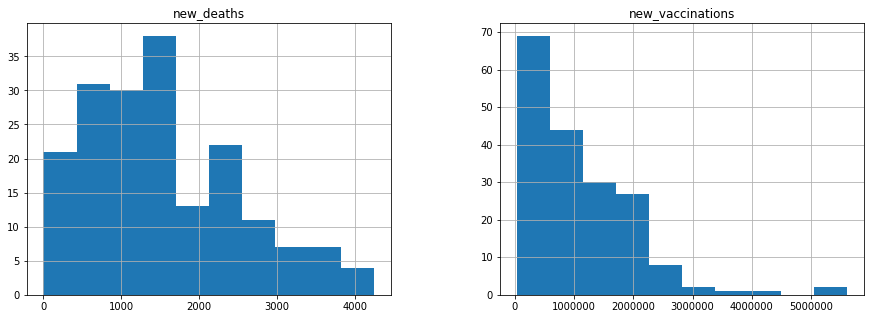

In [1576]:
filter_columns = [i for i in columns 
                  if i not in "date" 
                  and i not in "population"  
                  and i not in "people_vaccinated" 
                  and  i not in "people_fully_vaccinated"]
df_brasil[filter_columns].hist(figsize=(15, 5));

#### Seta a coluna date como index

In [1577]:
df_brasil_index_date = df_brasil.set_index(pd.DatetimeIndex(df_brasil['date']).to_period("M"))
df_brasil_index_date.drop("date", axis=1, inplace=True)

In [1578]:
df_brasil_index_date

,new_deaths,people_vaccinated,people_fully_vaccinated,new_vaccinations,population
date,,,,,
2021-02,0.00000,3399421.00000,1962.00000,326477.00000,213993441.00000
2021-02,1500.00000,3534004.00000,19677.00000,152298.00000,213993441.00000
2021-02,0.00000,3579850.00000,25688.00000,51857.00000,213993441.00000
2021-02,1986.00000,3786591.00000,33616.00000,214669.00000,213993441.00000
2021-02,1330.00000,4069677.00000,50655.00000,300125.00000,213993441.00000
...,...,...,...,...,...
2021-10,318.00000,158233397.00000,114767275.00000,5106732.00000,213993441.00000
2021-10,187.00000,158464224.00000,115489354.00000,948657.00000,213993441.00000
2021-10,433.00000,159200858.00000,118280562.00000,2565761.00000,213993441.00000


#### Plota gráfico de linha para analisarmos as tendências

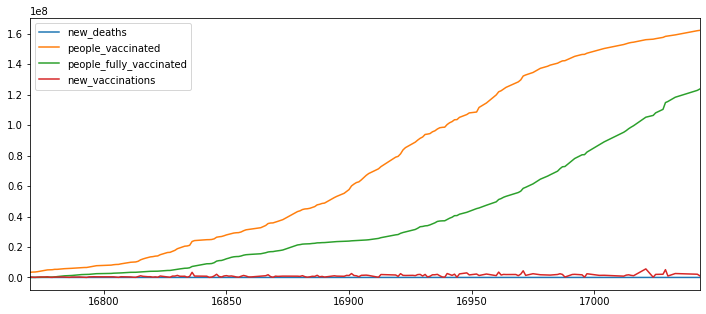

In [1579]:
filter_columns = [i for i in columns 
                  if i not in "date" 
                  and i not in "population" ]
df_brasil[filter_columns].astype(float).plot()

#### Plota gráfico mensal das variáveis *people_vaccinated* e *people_fully_vaccinated*

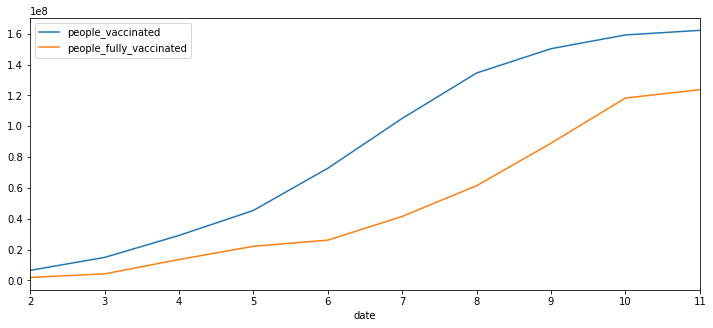

In [1580]:
months = df_brasil_index_date.index.month
df_brasil_index_date[["people_vaccinated", "people_fully_vaccinated"]].groupby(months).max().plot()

#### Plota gráfico mensal das variáveis *people_fully_vaccinated* e *new_deaths*

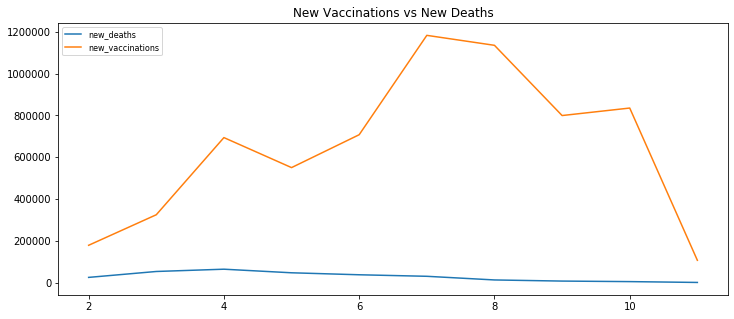

In [1581]:
new_deaths = df_brasil_index_date[["new_deaths"]].groupby(months).sum()
new_vaccionations = df_brasil_index_date[["new_vaccinations"]].groupby(months).sum() / 30

plt.plot(pd.DataFrame(new_deaths).set_index(new_deaths.index), label="new_deaths")
plt.plot(pd.DataFrame(new_vaccionations).set_index(new_vaccionations.index), label="new_vaccinations")

plt.title('New Vaccinations vs New Deaths')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Agrupa os dados mensalmente e monta a série

In [1582]:
months = df_brasil_index_date.index
ts_brasil_month = df_brasil[["people_vaccinated", "people_fully_vaccinated", "population"]].groupby(months).max()

In [1583]:
ts_brasil_month

,people_vaccinated,people_fully_vaccinated,population
date,,,
2021-02,6518628.00000,1914940.00000,213993441.00000
2021-03,14921376.00000,4234605.00000,213993441.00000
2021-04,29149512.00000,13549350.00000,213993441.00000
2021-05,45376214.00000,22106516.00000,213993441.00000
2021-06,72722360.00000,26105125.00000,213993441.00000
2021-07,105057816.00000,41489804.00000,213993441.00000
2021-08,134521410.00000,61416222.00000,213993441.00000
2021-09,150269515.00000,88983740.00000,213993441.00000
2021-10,159200858.00000,118280562.00000,213993441.00000


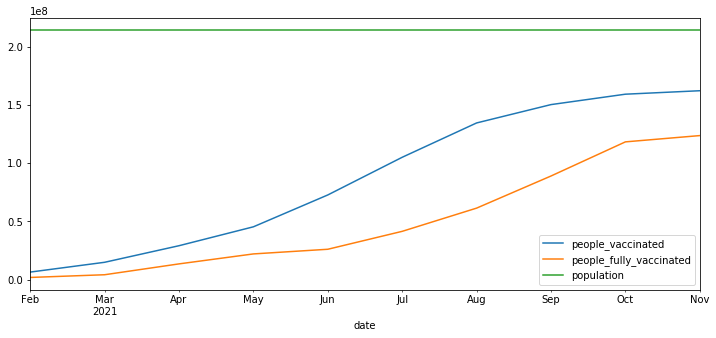

In [1584]:
ts_brasil_month.plot()

#### Separa o dataset em treino e teste

In [1585]:
train_size = round(len(ts_brasil_month) * 0.6)

In [1586]:
train_set = ts_brasil_month.people_fully_vaccinated.iloc[0: train_size]
test_set = ts_brasil_month.people_fully_vaccinated.iloc[train_size: -1]

In [1587]:
train_set.shape, test_set.shape

((6,), (3,))

#### Treina modelo utilizando biblioteca statsmodels

In [1588]:
from statsmodels.tsa.ar_model import AR

ar_model = AR(train_set, freq="M").fit(1)

#### Equação do modelo AR $Y_t$ = $C$ + $\phi_1$ * $Y_t$$_-$$_1$ + $\phi_2$ * $Y_t$$_-$$_2$ +...+ $Y_t$$_-$$_p$ + $\phi_p$

In [1589]:
ar_model.params

const                        4546827.70567
L1.people_fully_vaccinated         1.24798
dtype: float64

In [1590]:
const = model.params[0]
coef1 = model.params[1]
predictions =  const + coef1 * test_set.shift(1).dropna()

#### Avalia modelo

In [1591]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1592]:
print(mean_absolute_error(predictions, test_set[0:-1]))
print(np.sqrt(mean_squared_error(predictions, test_set[0:-1])))

4889815.901906073
4896023.033753497


#### Plota gráfico de linhas de treino, validação e predições

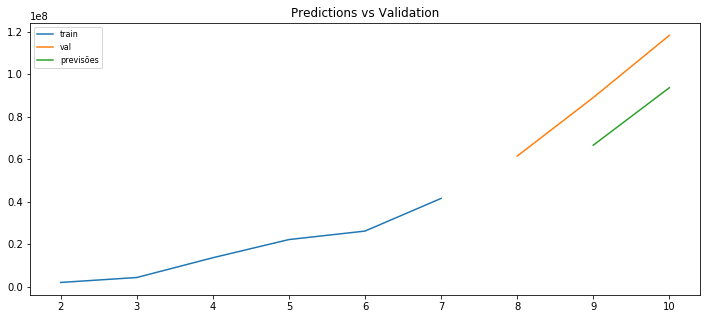

In [1593]:
plt.plot(pd.DataFrame(train_set).set_index(train_set.index.month), label='train')
plt.plot(pd.DataFrame(test_set).set_index(test_set.index.month), label='val')
plt.plot(pd.DataFrame(predictions).set_index(predictions.index.month), label="previsões")

plt.title('Predictions vs Validation')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Treina modelo utilizando biblioteca statsmodels

In [1594]:
from statsmodels.tsa.ar_model import AutoReg

In [1595]:
autoreg_model = AutoReg(train_set, lags=1).fit()

In [1596]:
start = train_set.shape[0]
end = train_set.shape[0] + test_set.shape[0]

In [1597]:
predictions = autoreg_model.predict(start=start, end=end - 1, dynamic=False)

#### Avalia o modelo

In [1598]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1599]:
print(mean_absolute_error(predictions[0:-1], test_set[0:-1]))
print(np.sqrt(mean_squared_error(predictions[0:-1], test_set[0:-1])))

9617224.999343589
10629190.529493276


#### Plota gráfico de linhas de treino, validação e predições

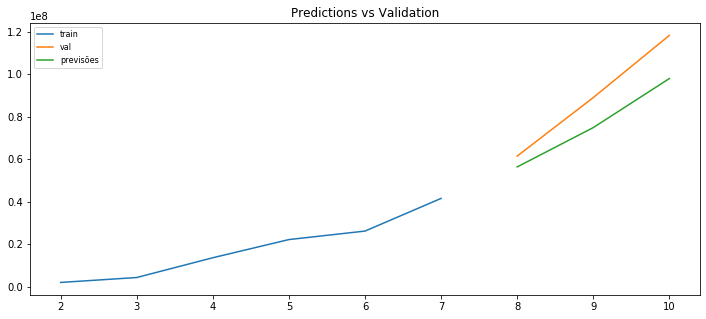

In [1600]:
plt.plot(pd.DataFrame(train_set).set_index(train_set.index.month), label='train')
plt.plot(pd.DataFrame(test_set).set_index(test_set.index.month), label='val')
plt.plot(pd.DataFrame(predictions).set_index(predictions.index.month), label="previsões")

plt.title('Predictions vs Validation')
plt.legend(loc='upper left', fontsize=8)
plt.show()

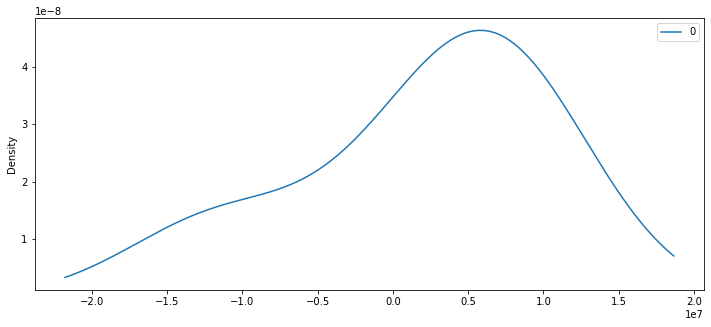

In [1601]:
pd.DataFrame(model_arima.resid).plot(kind="kde")

#### Plotando gráfico de residuos vs treinamento

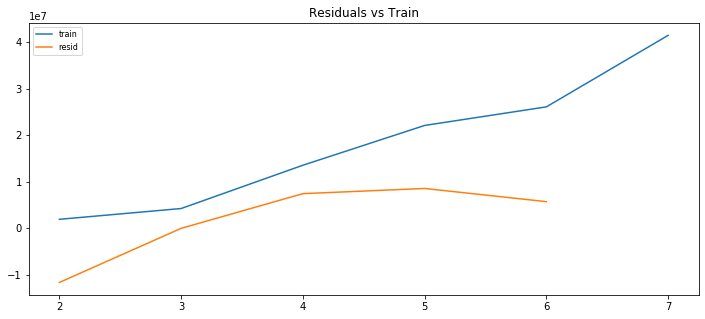

In [1602]:
plt.plot(pd.DataFrame(train_set).set_index(train_set.index.month), label='train')
plt.plot(pd.DataFrame(model_arima.resid).set_index(model_arima.resid.index.month), label='resid')

plt.title('Residuals vs Train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [1603]:
rate_vaccination = 0
n_periods = 0
while rate_vaccination < 1:
    

    start = train_set.shape[0]
    end = train_set.shape[0] + test_set.shape[0] + n_periods
    
    n_periods = n_periods + 1

    rate_vaccination_aux = autoreg_model.predict(start=start, end= end, dynamic=False) / df_brasil.population.unique()
    rate_vaccination = round(rate_vaccination_aux[-1], 2)
    
    print(f"Data: {rate_vaccination_aux.index[-1]}, Taxa de vacinação: {rate_vaccination}, Num Meses: {n_periods}")

Data: 2021-11, Taxa de vacinação: 0.59, Num Meses: 1
Data: 2021-12, Taxa de vacinação: 0.76, Num Meses: 2
Data: 2022-01, Taxa de vacinação: 0.97, Num Meses: 3
Data: 2022-02, Taxa de vacinação: 1.23, Num Meses: 4
